In [2]:
import seaborn as sns
import numpy as np
import pickle as pkl
import matplotlib as mpl
from graph_tool.generation import lattice
from graph_tool.draw import graph_draw
from itertools import chain
from collections import Counter
from tqdm import tqdm
from copy import copy

from graph_helpers import load_graph_by_name, extract_edges, extract_nodes
from viz_helpers import lattice_node_pos
from experiment import gen_input
from helpers import infected_nodes
from core import sample_steiner_trees
from tree_stat import TreeBasedStatistics
from random_steiner_tree.util import from_gt
from scipy.spatial.distance import cosine, euclidean

In [3]:
if False:
    g = lattice((10, 10))
    g.save('data/lattice-100/graph.gt')
else:
    g = load_graph_by_name('lattice-100', weighted=True)

load graph from data/lattice-100/graph_weighted.gt


In [4]:
pos = lattice_node_pos(g, (10, 10))
pos

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f8128f86b38, at 0x7f8128f864e0>

In [5]:
# color related

DEFAULT_COLOR_ID = 7
OBS_COLOR_ID = 4
QUERY_COLOR_ID = 1

DEFAULT_NODE_SIZE = 10
OBS_NODE_SIZE = 20
QUERY_NODE_SIZE = 25

pal = sns.color_palette("Set2", 10)
sns.palplot(pal)

In [6]:
p = g.edge_properties['weights']

if False:
    obs, c = gen_input(
        g, source=None,
        p=p, q=0.1,
        model='ic', min_size=10)

    pkl.dump((obs, c), open('cascade-weighted/lattice-100/1.pkl', 'wb'))
else:
    (obs, c) = pkl.load(open('cascade-weighted/lattice-100/1.pkl', 'rb'))

inf_nodes = infected_nodes(c)
    
print(len(inf_nodes))
source = np.nonzero(c == 0)[0][0]    

12


In [7]:
def draw_graph(node_color_array):
    node_color = g.new_vertex_property('float')
    for v in np.arange(g.num_vertices()):
        node_color[v] = node_color_array[v]

    vertex_size = g.new_vertex_property('int')
    vertex_size.a = OBS_NODE_SIZE
    # vertex_size.a[c < 0] = DEFAULT_NODE_SIZE
    # vertex_size.a[c >= 0] = OBS_NODE_SIZE

    vertex_order = g.new_vertex_property('int')
    vertex_order.a = (c + 1)

    edge_pen_width = g.new_edge_property('float')
    edge_pen_width.a = p.a * 7.5

    vertex_shape = g.new_vertex_property('string')
    vertex_shape.set_value('circle')
    # vertex_shape[source] = 'square'
    graph_draw(g, pos=pos, vertex_fill_color=node_color, vertex_size=vertex_size,
               vorder=vertex_order,
               edge_pen_width=edge_pen_width,
               vertex_shape=vertex_shape,
               vcmap=mpl.cm.Reds)
               # output=fig_root_dir+'/cascade.png')

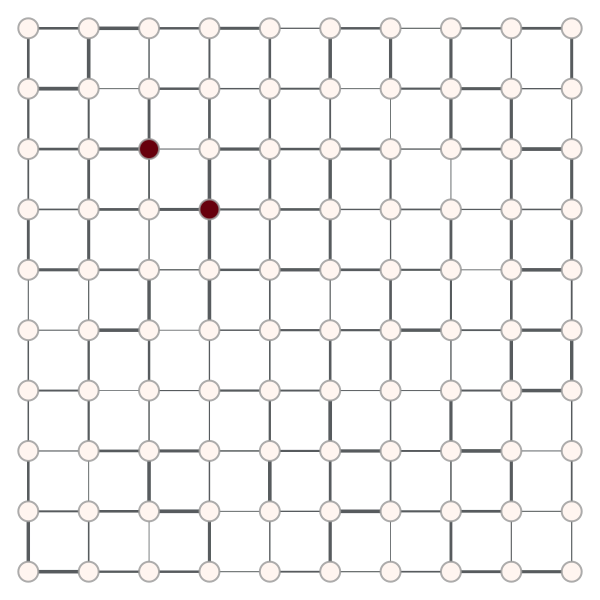

In [8]:
color = np.zeros(g.num_vertices())
color[list(obs)] = 1
draw_graph(color)

In [9]:
n_samples = 100

In [10]:
# method 1
# brute force sampling
brute_force_n_iters = 0
obs = set(obs)
brute_force_samples = []
for i in tqdm(range(n_samples)):
    while True:
        _, c_ = gen_input(
            g, source=None,
            p=p, q=0.1,
            model='ic', min_size=10)
        if obs.issubset(set(infected_nodes(c_))):    
            brute_force_samples.append(c_)
            break
        brute_force_n_iters += 1
print('used {} samples'.format(brute_force_n_iters))        

100%|██████████| 100/100 [00:19<00:00,  5.45it/s]

used 591 samples


In [11]:
freq = np.zeros(g.num_vertices())
for n in chain(*map(infected_nodes, brute_force_samples)):
    freq[n] += 1
brute_force_inf_probas = freq / n_samples    

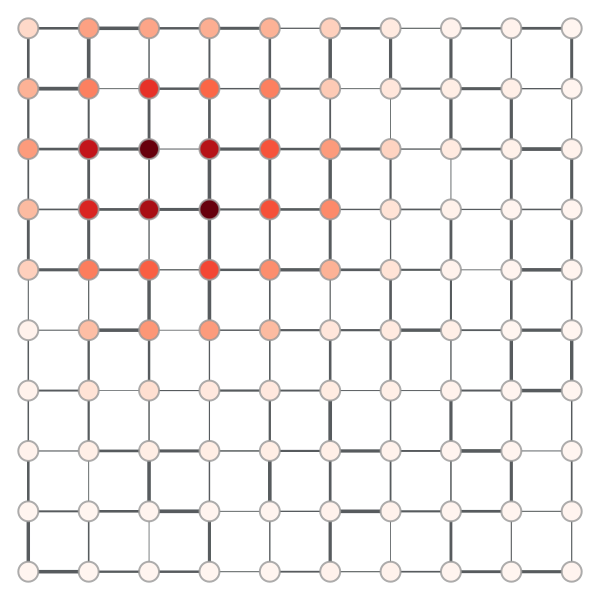

In [13]:
draw_graph(brute_force_inf_probas)

In [14]:
# method 2:
# vanilla steiner tree sampling
gi = from_gt(g)
st_tree_nodes = sample_steiner_trees(g, obs, root=None,
                                     method='cut', n_samples=1000, gi=gi, return_tree_nodes=True)

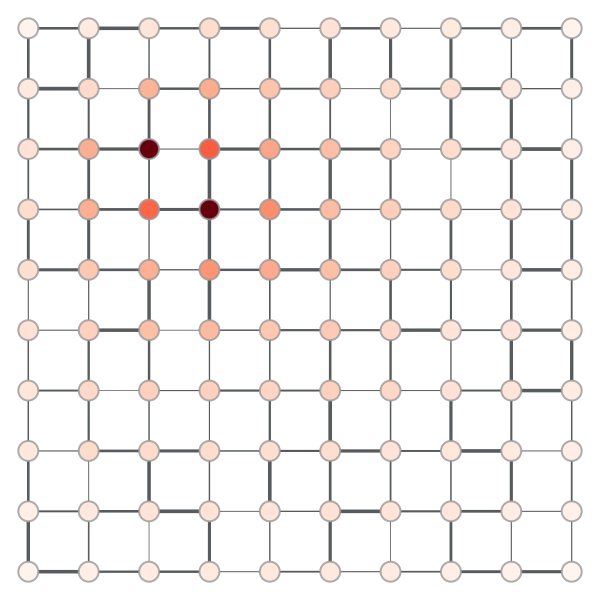

In [15]:
node_stat = TreeBasedStatistics(g, st_tree_nodes)
st_naive_probas = node_stat.unconditional_proba()
draw_graph(st_naive_probas)

In [18]:
# method 3
# with incremental cascade simulation
def incremental_simulation(g, c, p, return_new_edges=False):
    visited = {v: False for v in np.arange(g.num_vertices())}
    new_c = copy(c)
    for v in infected_nodes(c):
        visited[v] = True

    if return_new_edges:
        new_edges = []
        
    queue = list(infected_nodes(c))
    while len(queue) > 0:
        u = queue.pop(0)
        uu = g.vertex(u)
        for e in uu.out_edges():
            v = int(e.target())        
            if np.random.random() <= p[e] and not visited[v]:  # active
                if return_new_edges:
                    new_edges.append((u, v))
                new_c[v] = c[u] + 1
                visited[v] = True
                queue.append(v)

    if return_new_edges:
        return (new_c, new_edges)
    else:
        return new_c



In [19]:
st_tree_nodes = sample_steiner_trees(g, obs, root=None,
                                     method='cut', n_samples=100, gi=gi, return_tree_nodes=True)
new_tree_nodes = []
for nodes in st_tree_nodes:
    fake_c = np.ones(g.num_vertices()) * (-1)
    fake_c[list(nodes)] = 1
    new_c = incremental_simulation(g, fake_c, p, return_new_edges=False)
    new_tree_nodes.append(infected_nodes(new_c))

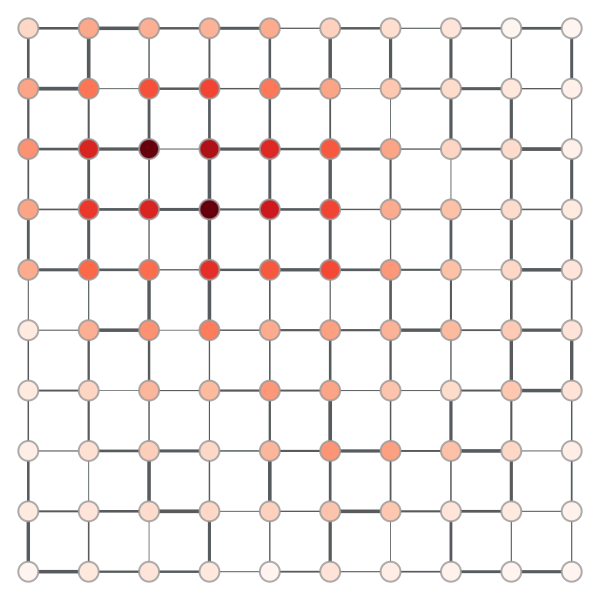

In [20]:
node_stat = TreeBasedStatistics(g, new_tree_nodes)
st_tree_inc_probas = node_stat.unconditional_proba()
draw_graph(st_tree_inc_probas)

In [23]:
# method 4
# method 3 + importance sampling
def steiner_tree_proba(g, tree_edges, edge_proba):
    degree_map = g.degree_property_map('out', edge_proba)  # weighted degree
    numers = np.array([edge_proba[g.edge(u, v)] for u, v in tree_edges])
    
    denums = np.array([degree_map[u] for u, _ in tree_edges])    

    return np.product(numers / denums)

In [24]:
st_trees = sample_steiner_trees(g, obs, root=None,
                                method='cut', n_samples=100, gi=gi, return_tree_nodes=False)

In [25]:
edges_of_trees = list(map(extract_edges, st_trees))
# extract_nodes(st_trees[0])

In [26]:
new_edges_of_trees = []
for tree in st_trees:
    fake_c = np.ones(g.num_vertices()) * (-1)
    fake_c[list(nodes)] = 1
    _, new_edges = incremental_simulation(g, fake_c, p, return_new_edges=True)    
    new_edges_of_trees.append(new_edges)

In [27]:
def steiner_tree_proba_adjusted(g, tree_edges, new_infection_edges, edge_proba):
    degree_map = g.degree_property_map('out', edge_proba)  # weighted degree    
    c_proba = cascade_proba(g, tree_edges + new_infection_edges, edge_proba)
    denum = np.product([degree_map[u] for u, _ in tree_edges])  # devided by w(u) for each (u, v)
    return c_proba / denum

In [28]:
def cascade_proba(g, pos_edges, p):
    nodes = {u for e in pos_edges for u in e}
    neg_edges = {tuple(sorted((u, int(v))))
                 for u in nodes
                 for v in g.vertex(u).out_neighbours()  # uninfected nodes
                 if int(v) not in nodes}
    probas_from_neg_edges = [(1 - p[g.edge(*e)]) for e in neg_edges]
    probas_from_pos_edges = [p[g.edge(*e)] for e in pos_edges]

    return np.product(probas_from_pos_edges + probas_from_neg_edges)

In [29]:
tree_probas = np.array(list(map(
    lambda tpl: steiner_tree_proba_adjusted(
        g, extract_edges(tpl[0]), tpl[1], p),
    zip(st_trees, new_edges_of_trees))))

In [30]:
cascade_probas = np.array(list(map(
    lambda tpl: cascade_proba(g, extract_edges(tpl[0]) + tpl[1], p), 
    zip(st_trees, new_edges_of_trees)
)))


In [31]:
adjusted_probas = (cascade_probas / tree_probas)
adjusted_probas /= adjusted_probas.sum()

In [32]:
sampled_tree_ids = np.random.choice(np.arange(n_samples), size=n_samples, replace=True, p=adjusted_probas)

In [33]:
resampled_tree_nodes = []
for i in sampled_tree_ids:
    nodes = {u for e in (edges_of_trees[i] + new_edges_of_trees[i]) for u in e}
    resampled_tree_nodes.append(nodes)
    

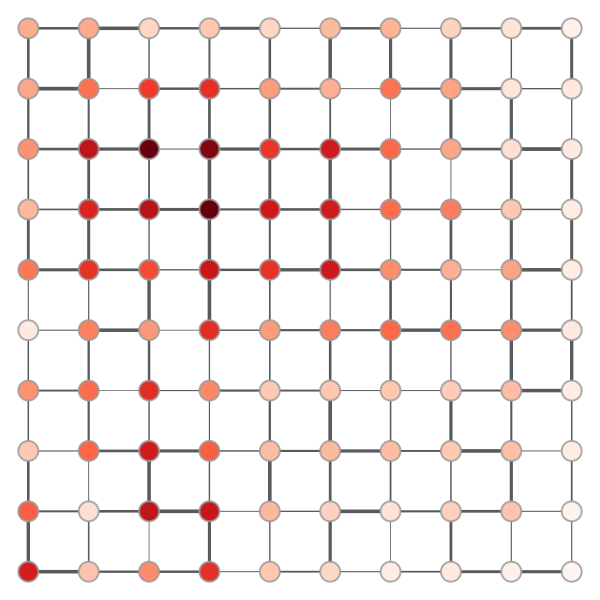

In [34]:
node_stat = TreeBasedStatistics(g, resampled_tree_nodes)
st_adjusted_probas = node_stat.unconditional_proba()
draw_graph(st_adjusted_probas)

In [37]:
# method 5
# importance sampling on the problem formulation


st_trees = sample_steiner_trees(g, obs, root=None,                                
                                method='cut', n_samples=100, gi=gi, return_tree_nodes=False)
edges_of_trees = list(map(extract_edges, st_trees))



In [38]:
def steiner_tree_sample_weight(g, tree_edges, edge_proba):
    degree_map = g.degree_property_map('out', edge_proba)  # weighted degree    
    denums = np.array([degree_map[u] for u, _ in tree_edges])    

    return np.product(denums)



In [39]:
tree_weights = np.array(list(map(lambda t: steiner_tree_sample_weight(g, t, p), edges_of_trees)))

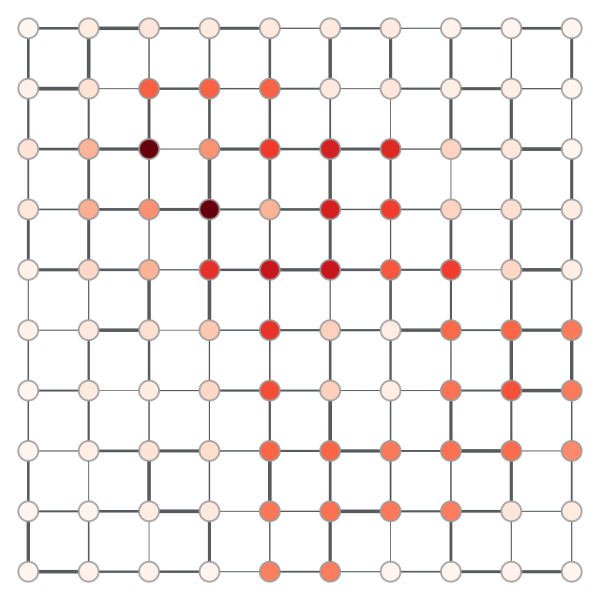

In [40]:
adj_probas = tree_weights / tree_weights.sum()
sampled_tree_ids = np.random.choice(np.arange(n_samples), size=n_samples, replace=True, p=adj_probas)
resampled_tree_nodes = []
for i in sampled_tree_ids:
    nodes = {u for e in edges_of_trees[i] for u in e}
    resampled_tree_nodes.append(nodes)
node_stat = TreeBasedStatistics(g, resampled_tree_nodes)
st_adjusted_probas_5 = node_stat.unconditional_proba()
draw_graph(st_adjusted_probas_5)    

In [42]:
for v in [st_naive_probas, st_tree_inc_probas, st_adjusted_probas, st_adjusted_probas_5]:
    print(euclidean(brute_force_inf_probas, v))

1.3930624537327823
1.9296890941288962
2.846102598291214
2.783594798098315
